In [2]:
%cd ..
%load_ext autoreload
%autoreload 2

/home/moshida/EUVlitho


In [2]:
from elitho.mask_pattern import LinePattern
from elitho import const
from elitho import fourier

mask = LinePattern(cd=56, gap=80, direction="V", field_type="DF")(const.NDIVX, const.NDIVY)

/home/moshida/.pyenv/versions/3.12.11/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


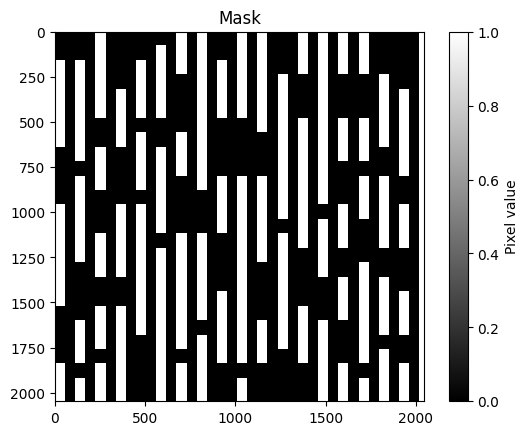

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(mask, cmap='gray', interpolation='nearest')
plt.title("Mask")
plt.colorbar(label="Pixel value")
plt.show()

In [4]:
# cpu
import numpy as np
from elitho import const, multilayer, absorber
polar = "X"
nsx=0
nsy=0
sx0 = 2.0 * const.pi / const.dx * nsx / const.ndivs + const.kx0
sy0 = 2.0 * const.pi / const.dy * nsy / const.ndivs + const.ky0
kx0 = sx0
ky0 = sy0
#
kxplus = kx0 + 2 * const.pi * np.array(const.lindex) / const.dx
kyplus = ky0 + 2 * const.pi * np.array(const.mindex) / const.dy
kxy2 = kxplus**2 + kyplus**2
k = const.k
matrix_size = const.Nrange
epsN, etaN, zetaN, sigmaN = fourier.coefficients(mask)


# --- 3.calc absorber sequencially from the most above layer ---
U1U, U1B = multilayer.multilayer_transfer_matrix(
    polar, const.Nrange, kxplus, kyplus, kxy2
)

# --- 4. calc initial B matrix ---
if polar == "X":
    Bru = np.diag(
        const.i_complex * const.k
        - const.i_complex / const.k / const.epsilon_ru * kxplus**2
    )
else:
    Bru = np.diag(
        const.i_complex * const.k
        - const.i_complex / const.k / const.epsilon_ru * kyplus**2
    )

B = Bru
al = np.sqrt(const.k**2 * const.epsilon_ru - kxy2)
br = np.eye(const.Nrange, dtype=complex)

In [5]:
%%time
for n in reversed(range(const.NABS)):
    eps, eta, zeta, sigma = epsN[n], etaN[n], zetaN[n], sigmaN[n]
    dabs = const.dabs[n]
    U1U, U1B, B, al, br = absorber.absorber(
        polar,
        kxplus,
        kyplus,
        kxy2,
        eps,
        eta,
        zeta,
        sigma,
        dabs,
        al,
        br,
        B,
        U1U,
        U1B,
    )

numpy
CPU times: user 2h 8min, sys: 11.1 s, total: 2h 8min 11s
Wall time: 9min 17s


In [5]:
# gpu ver
import cupy as cp

mask = cp.array(mask)
kxplus = kx0 + 2 * const.pi * cp.array(const.lindex) / const.dx
kyplus = ky0 + 2 * const.pi * cp.array(const.mindex) / const.dy
kxy2 = kxplus**2 + kyplus**2
epsN, etaN, zetaN, sigmaN = fourier.coefficients(mask)
U1U, U1B = multilayer.multilayer_transfer_matrix(
    polar, const.Nrange, kxplus, kyplus, kxy2
)
# --- 4. calc initial B matrix ---
if polar == "X":
    Bru = cp.diag(
        const.i_complex * const.k
        - const.i_complex / const.k / const.epsilon_ru * kxplus**2
    )
else:
    Bru = cp.diag(
        const.i_complex * const.k
        - const.i_complex / const.k / const.epsilon_ru * kyplus**2
    )
B = Bru
al = cp.sqrt(const.k**2 * const.epsilon_ru - kxy2)
br = cp.eye(const.Nrange, dtype=complex)

In [6]:
%%time
for n in reversed(range(const.NABS)):
    eps, eta, zeta, sigma = epsN[n], etaN[n], zetaN[n], sigmaN[n]
    dabs = const.dabs[n]
    U1U, U1B, B, al, br = absorber.absorber(
        polar,
        kxplus,
        kyplus,
        kxy2,
        eps,
        eta,
        zeta,
        sigma,
        dabs,
        al,
        br,
        B,
        U1U,
        U1B,
    )

cupy
CPU times: user 1h 28min 15s, sys: 1h 9min 28s, total: 2h 37min 44s
Wall time: 35min 10s


In [1]:
%%time
for n in reversed(range(const.NABS)):
    eps, eta, zeta, sigma = epsN[n], etaN[n], zetaN[n], sigmaN[n]
    dabs = const.dabs[n]
    U1U, U1B, B, al, br = absorber.absorber(
        polar,
        kxplus,
        kyplus,
        kxy2,
        eps,
        eta,
        zeta,
        sigma,
        dabs,
        al,
        br,
        B,
        U1U,
        U1B,
    )

NameError: name 'const' is not defined

In [8]:
a = cp.ones((10, 10))

In [11]:
np_a = cp.asnumpy(a)

In [13]:
type(np_a), np_a.shape

(numpy.ndarray, (10, 10))

In [21]:
%load_ext autoreload
from elitho.utils.mat_utils import cupy_eig

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
cupy_eig(a)

ModuleNotFoundError: No module named 'cupy.cuda.solver'

In [3]:
from elitho import const
const.Nrange

8705